# LLM Judgment - Human Judgment as a Target

This experiments applied the signed differecnes of LLM labels and human labels as a target for analysis the features.

In [11]:
import pandas as pd
import glob
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf

### Plots for Model Assumptions

In [12]:
## Function to check model assumptions 
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_residuals(result):
    
    # Extract residuals and fitted values
    residuals = result.resid
    fitted_values = result.fittedvalues

    # Q-Q plot
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Residuals vs. Fitted values
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

### Plot for Coefficients

In [13]:
def plot_coef(result):
    
    # Step 1: Extract the coefficients and p-values
    coefficients = result.params
    p_values = result.pvalues

    print("Coefficients from the model:")
    print("P-values from the model:")

    # Step 2: Plot the coefficients with p-values
    # Convert coefficients and p-values to a DataFrame for easy plotting
    coeff_df = pd.DataFrame({
        'coefficients': coefficients,
        'p_values': p_values,
        'features': coefficients.index
    })

    # Create the bar plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(coeff_df['features'], coeff_df['coefficients'], color='skyblue')

    # Add the p-values as text annotations next to each bar
    for bar, p_value in zip(bars, coeff_df['p_values']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'p = {p_value:.3f}', 
                va='center', ha='left', fontsize=10)

    # Add titles and labels
    plt.title('Extracted Coefficients with P-Values from the Model')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.grid(True)

    # Display the plot
    plt.show()

### Data

In [14]:
# Load each text file into a DataFrame
qrel_human_df = pd.read_csv('./qrels/2023.qrels.pass.withDupes.txt', delimiter=' ', header=None, names=['qid', 'Q0', 'docid', 'label'])  # adjust delimiter if necessary
qrel_llm_df = pd.read_csv('./qrels/2023.qrels.pass.gpt4.txt', delimiter=' ', header=None, names=['qid', 'Q0', 'docid', 'label'])

# Merge the two DataFrames based on a common column, e.g., 'id'
qrels_df = pd.merge(qrel_human_df, qrel_llm_df, on=['qid', 'docid'])

qrels_df.drop(['Q0_x'], axis=1, inplace=True)
qrels_df.drop(['Q0_y'], axis=1, inplace=True)

qrels_df.rename(columns={'label_x': 'label_human'}, inplace=True)
qrels_df.rename(columns={'label_y': 'label_llm'}, inplace=True)

qrels_df['llm_human_diff'] = qrels_df['label_llm'] - qrels_df['label_human']

# Display or save the merged DataFrame
# print(qrels_df['llm-human'])

In [15]:
queries_judged = set(qrels_df['qid'])
real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

In [16]:
qid_to_info = pd.read_csv("infos/query_to_info.txt", sep='\t')
doc_to_info = pd.read_csv("infos/doc_to_info.txt", sep='\t')

In [17]:
data = pd.merge(qrels_df, qid_to_info, on='qid')
data = pd.merge(data, doc_to_info, on='docid')

In [18]:
data.head(20)
print(data)
#data.describe

           qid                         docid  label_human  label_llm  \
0      2001010  msmarco_passage_00_257661787            0          0   
1      2001010  msmarco_passage_00_257662430            0          0   
2      2001010  msmarco_passage_00_257664103            0          0   
3      2001010  msmarco_passage_00_729310942            0          1   
4      2001010  msmarco_passage_00_729315698            1          1   
...        ...                           ...          ...        ...   
24244  3100922  msmarco_passage_61_425158788            0          1   
24245  3100922  msmarco_passage_64_139007780            0          0   
24246  3100922   msmarco_passage_67_28012312            0          0   
24247  3100922   msmarco_passage_67_95950055            0          0   
24248  3100922  msmarco_passage_68_194985280            0          0   

       llm_human_diff  QL     QDR     QDS  QW       APL  QT  isGPT4  PW  
0                   0   0  0.7840  0.7023   6   72.5291   0  

In [51]:
data['QT'] = data['QT'].astype('category')

### Modelling LLM Label 

In [52]:
mixed_model_1 = "label_llm ~ label_human * (QL + QW + PW + QT)"
mixed_model = "llm_human_diff ~ QL + QW + QT+ PW"
mixed_model_int = "llm_human_diff ~ QT * (QL + QW + PW)"

In [53]:
model = sm.MixedLM.from_formula(mixed_model_1, data, groups=data["docid"])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM   Dependent Variable:   label_llm  
No. Observations:   24249     Method:               REML       
No. Groups:         21873     Scale:                0.2690     
Min. group size:    1         Log-Likelihood:       -28576.5071
Max. group size:    324       Converged:            Yes        
Mean group size:    1.1                                        
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.401    0.022  17.905 0.000  0.357  0.445
QT[T.1]             -0.082    0.016  -5.189 0.000 -0.112 -0.051
QT[T.2]             -0.100    0.021  -4.722 0.000 -0.141 -0.058
label_human          0.480    0.023  20.668 0.000  0.434  0.525
label_human:QT[T.1] -0.182    0.015 -12.361 0.000 -0.211 -0.153
label_human:QT[T.2] -0.073    0.019  -3.896 0.000 -0.109 -0.036
QL                  -0.245    0.029  -8.378 0.000 -0.302 -0.187
QW                   0.039    0.004  10.594 0.000  0.031  0.046
PW                  -0.000    0.000  -5.538 0.000 -0.000 -0.000
label_human:QL      -0.073    0.027  -2.745 0.006 -0.126 -0.021
label_human:QW       0.015    0.003   4.593 0.000  0.008  0.021
label_human:PW       0.000    0.000   0.346 0.729 -0.000  0.001
Group Var            0.393    0.041                            
===============================================================

"""

Coefficients from the model:
P-values from the model:


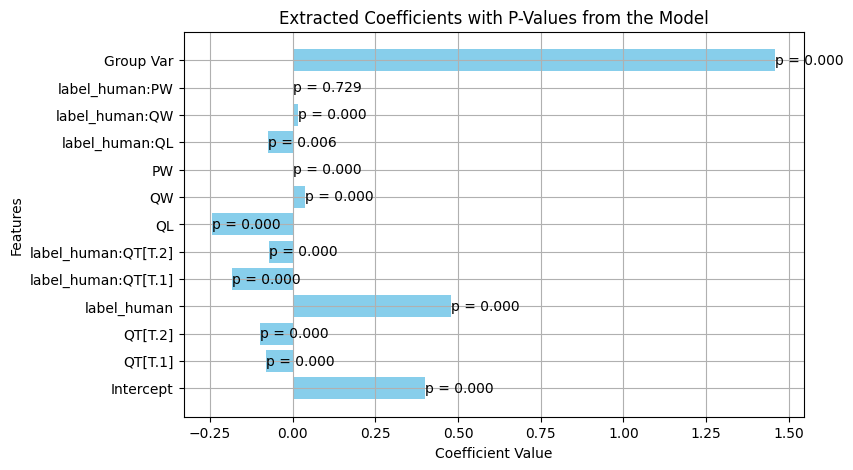

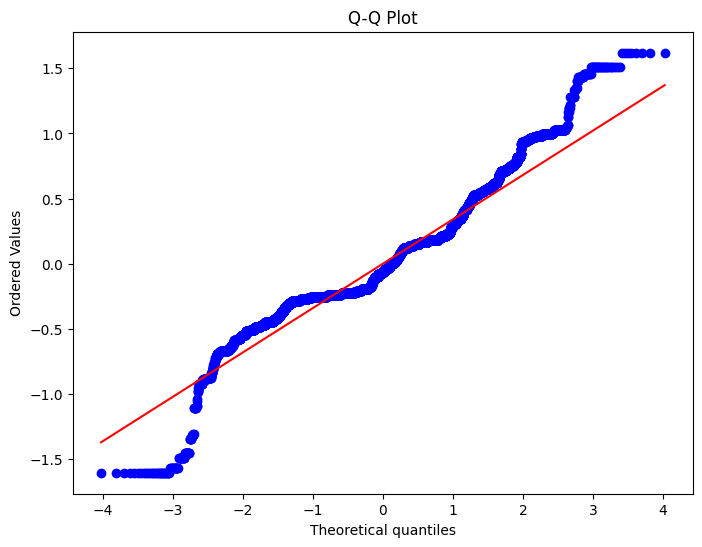

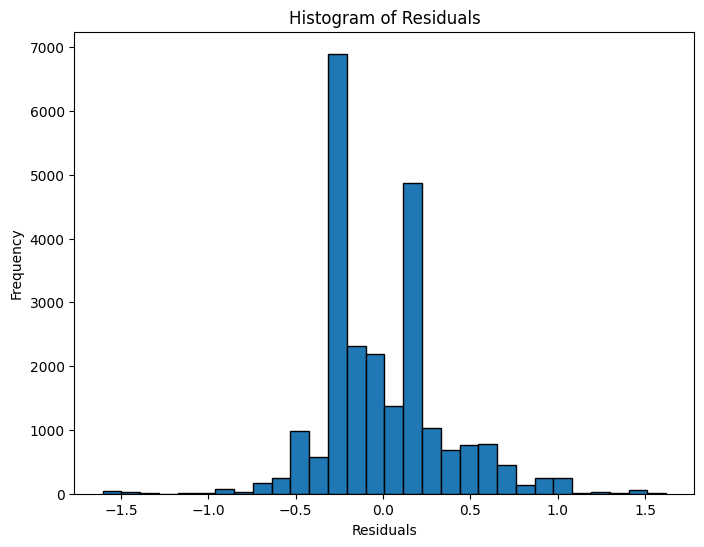

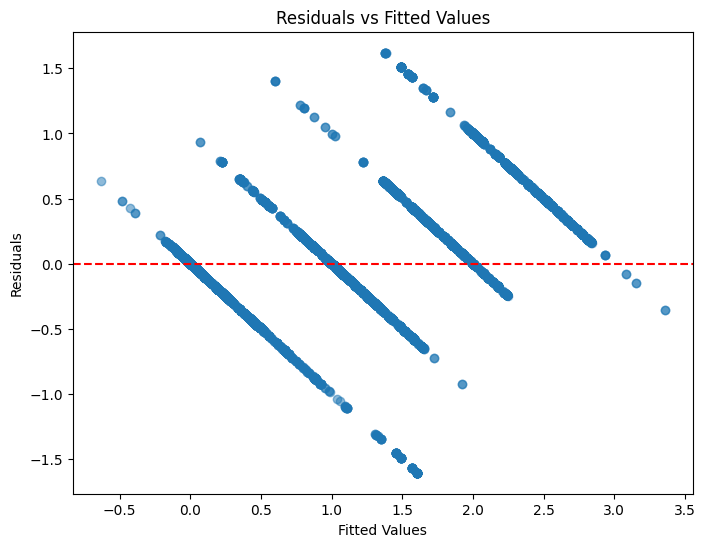

In [54]:
plot_coef(result)
plot_residuals(result)

In [55]:
model = smf.glm(formula=mixed_model_1, data=data, family=sm.families.Poisson())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              label_llm   No. Observations:                24249
Model:                            GLM   Df Residuals:                    24237
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27227.
Date:                Mon, 07 Oct 2024   Deviance:                       22985.
Time:                        14:23:01   Pearson chi2:                 2.18e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2359
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.8669      0.037    -23.496      0.000      -0.939      -0.795
QT[T.1]                -0.1855      0.027     -6.939      0.000      -0.238      -0.133
QT[T.2]                -0.2662      0.034     -7.839      0.000      -0.333      -0.200
label_human             0.5529      0.025     22.148      0.000       0.504       0.602
label_human:QT[T.1]    -0.0322      0.016     -1.954      0.051      -0.065       0.000
label_human:QT[T.2]     0.0306      0.020      1.541      0.123      -0.008       0.070
QL                     -0.3328      0.049     -6.827      0.000      -0.428      -0.237
QW                      0.0682      0.006     11.509      0.000       0.057       0.080
PW                   -3.31e-06   3.01e-06     -1.098      0.272   -9.22e-06     2.6e-06
label_human:QL          0.0754      0.029      2.631      0.009       0.019       0.132
label_human:QW         -0.0158      0.003     -4.601      0.000      -0.023      -0.009
label_human:PW          0.0003      0.000      1.276      0.202      -0.000       0.001
=======================================================================================
"""

Coefficients from the model:
P-values from the model:


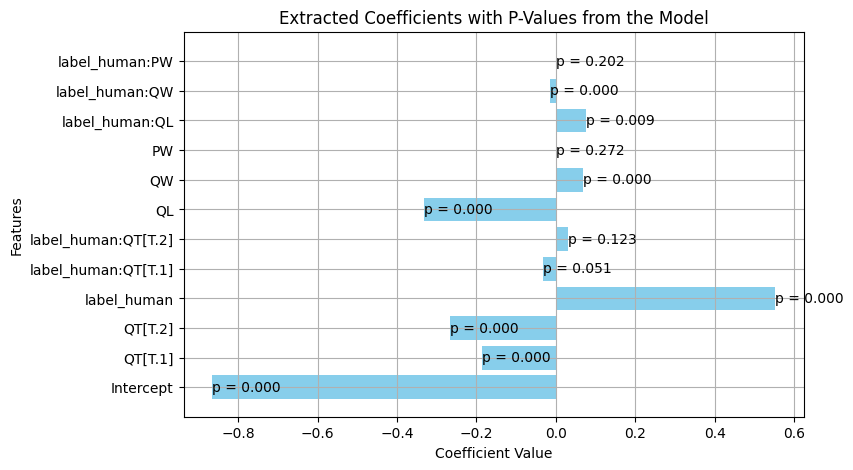

In [56]:
plot_coef(result)

In [57]:
data_log = data.copy()

data_log['label_llm'] = np.log(data_log['label_llm'])
model = model = sm.MixedLM.from_formula(mixed_model_1, data, groups=data_log["docid"])

result = model.fit()
result.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM   Dependent Variable:   label_llm  
No. Observations:   24249     Method:               REML       
No. Groups:         21873     Scale:                0.2690     
Min. group size:    1         Log-Likelihood:       -28576.5071
Max. group size:    324       Converged:            Yes        
Mean group size:    1.1                                        
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.401    0.022  17.905 0.000  0.357  0.445
QT[T.1]             -0.082    0.016  -5.189 0.000 -0.112 -0.051
QT[T.2]             -0.100    0.021  -4.722 0.000 -0.141 -0.058
label_human          0.480    0.023  20.668 0.000  0.434  0.525
label_human:QT[T.1] -0.182    0.015 -12.361 0.000 -0.211 -0.153
label_human:QT[T.2] -0.073    0.019  -3.896 0.000 -0.109 -0.036
QL                  -0.245    0.029  -8.378 0.000 -0.302 -0.187
QW                   0.039    0.004  10.594 0.000  0.031  0.046
PW                  -0.000    0.000  -5.538 0.000 -0.000 -0.000
label_human:QL      -0.073    0.027  -2.745 0.006 -0.126 -0.021
label_human:QW       0.015    0.003   4.593 0.000  0.008  0.021
label_human:PW       0.000    0.000   0.346 0.729 -0.000  0.001
Group Var            0.393    0.041                            
===============================================================

"""

In [60]:
data_cat = data.copy()

data_cat = pd.melt(data_cat, value_vars = ['label_human', 'label_llm'], 
                   id_vars = ['QL',
       'QDR', 'QDS', 'QW', 'PW', 'QT', 'qid', 'docid'],
              var_name = 'label_type', value_name = 'label')


print(data_cat)

mixed_model = "label ~ label_type * (QW + PW + QT)"


model = sm.MixedLM.from_formula(mixed_model, data_cat, groups=data_cat["docid"])
result = model.fit()
result.summary()

       QL     QDR     QDS  QW  PW QT      qid                         docid  \
0       0  0.7840  0.7023   6  56  0  2001010  msmarco_passage_00_257661787   
1       0  0.7840  0.7023   6  43  0  2001010  msmarco_passage_00_257662430   
2       0  0.7840  0.7023   6  46  0  2001010  msmarco_passage_00_257664103   
3       0  0.7840  0.7023   6  47  0  2001010  msmarco_passage_00_729310942   
4       0  0.7840  0.7023   6  45  0  2001010  msmarco_passage_00_729315698   
...    ..     ...     ...  ..  .. ..      ...                           ...   
48493   1  0.0383  0.5447  10  54  2  3100922  msmarco_passage_61_425158788   
48494   1  0.0383  0.5447  10  27  2  3100922  msmarco_passage_64_139007780   
48495   1  0.0383  0.5447  10  50  2  3100922   msmarco_passage_67_28012312   
48496   1  0.0383  0.5447  10  48  2  3100922   msmarco_passage_67_95950055   
48497   1  0.0383  0.5447  10  65  2  3100922  msmarco_passage_68_194985280   

        label_type  label  
0      label_human     

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                  MixedLM       Dependent Variable:       label      
No. Observations:       48498         Method:                   REML       
No. Groups:             21873         Scale:                    0.4087     
Min. group size:        2             Log-Likelihood:           -60985.4314
Max. group size:        648           Converged:                Yes        
Mean group size:        2.2                                                
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.851    0.017  48.916 0.000  0.817  0.885
label_type[T.label_llm]          0.031    0.017   1.792 0.073 -0.003  0.064
QT[T.1]                         -0.155    0.016  -9.787 0.000 -0.186 -0.124
QT[T.2]                         -0.077    0.019  -3.987 0.000 -0.114 -0.039
label_type[T.label_llm]:QT[T.1] -0.060    0.016  -3.788 0.000 -0.091 -0.029
label_type[T.label_llm]:QT[T.2] -0.256    0.019 -13.425 0.000 -0.293 -0.219
QW                              -0.022    0.003  -8.127 0.000 -0.027 -0.016
label_type[T.label_llm]:QW       0.043    0.003  16.480 0.000  0.038  0.048
PW                              -0.000    0.000  -9.067 0.000 -0.000 -0.000
label_type[T.label_llm]:PW       0.000    0.000   9.171 0.000  0.000  0.000
Group Var                        0.504    0.014                            
===========================================================================

"""

/var/folders/lf/qlbvylsd4vj06bh72p5kb5hh0000gp/T/ipykernel_90191/873189737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype('category')


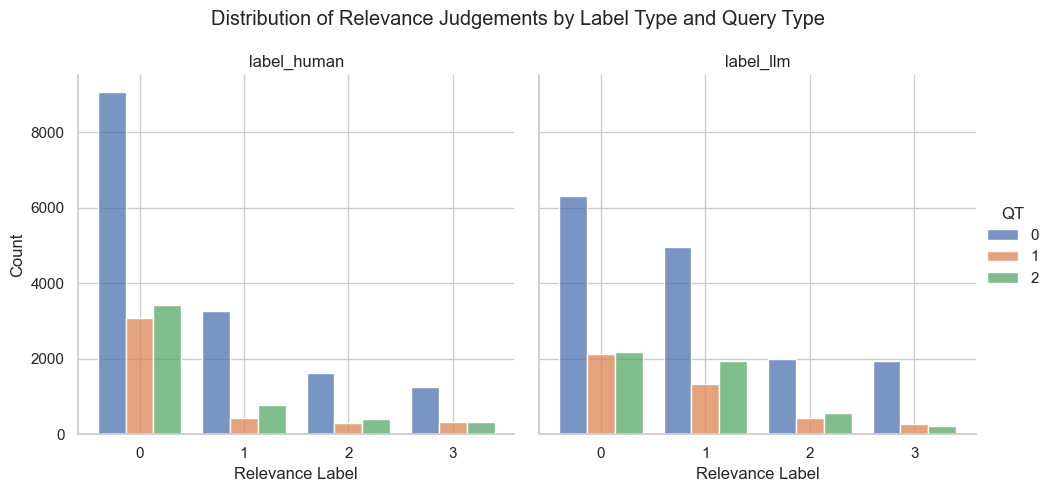

In [109]:
df = data_cat[['label', 'label_type', 'QW', 'PW', 'QT']]
df['label'] = df['label'].astype('category')

import seaborn as sns


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a FacetGrid for the label type
g = sns.FacetGrid(df, col="label_type", hue="QT", height=5)

# Add a histogram to the FacetGrid
g.map(sns.histplot, 'label', stat="count", hue = 'QT', multiple='dodge', shrink = .8, common_norm=False, data = df)

# Adjust the titles and labels
g.add_legend()
g.set_axis_labels("Relevance Label", "Count")
g.set_titles(col_template="{col_name}")

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Relevance Judgements by Label Type and Query Type')

# Show the plot
plt.xticks([0, 1, 2, 3])  # Set y-ticks to 0, 1, 2, 3
plt.show()

/var/folders/lf/qlbvylsd4vj06bh72p5kb5hh0000gp/T/ipykernel_90191/2162239002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype('category')
/var/folders/lf/qlbvylsd4vj06bh72p5kb5hh0000gp/T/ipykernel_90191/2162239002.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['QT'] = df['QT'].replace({0: 'Human generated Query', 1: 'T5 generated Query', 2: 'GPT-4 generated Query'})
/var/folders/lf/qlbvylsd4vj06bh72p5kb5hh0000gp/T/ipykernel_90191/2162239002.py:3: SettingWithCopyWarning: 
A value is trying to b

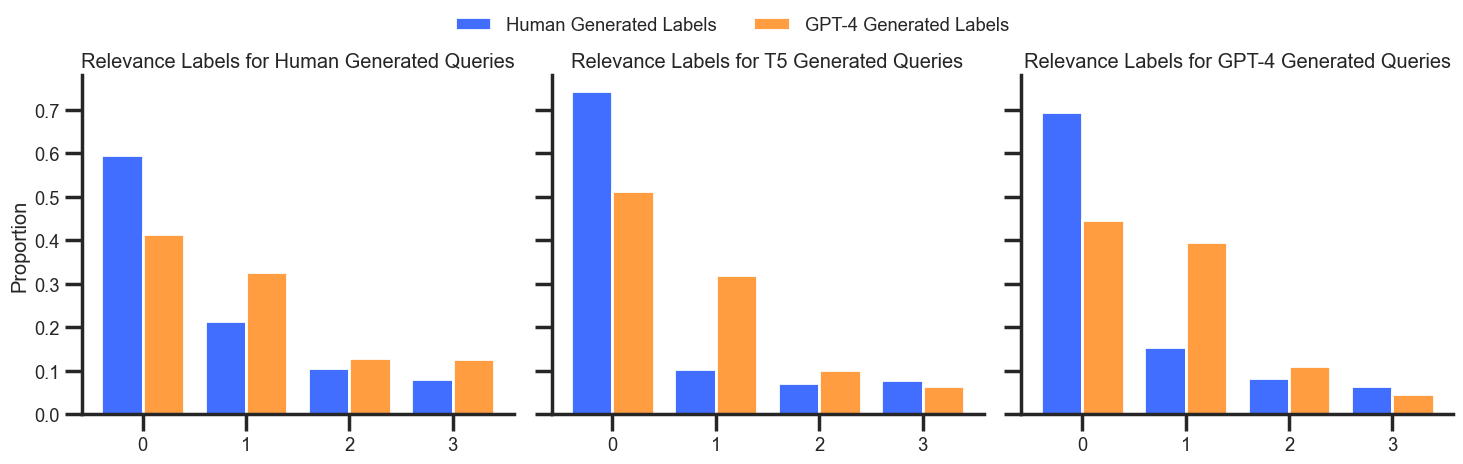

In [155]:
df = data_cat[['label', 'label_type', 'QW', 'PW', 'QT']]
df['label'] = df['label'].astype('category')
df['QT'] = df['QT'].replace({0: 'Human generated Query', 1: 'T5 generated Query', 2: 'GPT-4 generated Query'})
df['label_type'] = df['label_type'].replace({'label_human': 'Human Generated Labels', 'label_llm':'GPT-4 Generated Labels'})


import seaborn as sns


sns.set_style("ticks")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_context("poster", font_scale =0.6)     # Options: paper, notebook, talk, poster
sns.set_palette("bright")   # You can also use: deep, muted, bright, dark, colorblind, or a custom list of colors

# Create a FacetGrid for the label type
g = sns.FacetGrid(df, col="QT", hue="label_type", height=5)

# Add a histogram to the FacetGrid
g.map(sns.histplot, 'label', stat="proportion", hue = 'label_type', multiple='dodge', shrink = .8, common_norm=False, data = df)

# Adjust the titles and labels
g.add_legend()
g.set_axis_labels("", "Proportion")
g.set_titles(col_template="{col_name}")

titles = ['Relevance Labels for Human Generated Queries', 'Relevance Labels for T5 Generated Queries', 'Relevance Labels for GPT-4 Generated Queries']

for ax, title in zip(g.axes.flatten(),titles):
    ax.set_title(title)
    
sns.move_legend(g, ncol=3, loc='upper center', title = '')

# Adjust layout
plt.subplots_adjust(top=0.85)

# Show the plot
plt.xticks([0, 1, 2, 3])  # Set y-ticks to 0, 1, 2, 3
plt.savefig("figs/label_barplots.pdf", bbox_inches="tight")
plt.show()


In [158]:
import pandas as pd
from scipy.stats import chi2_contingency

# Contingency table
contingency_table = pd.crosstab(df['label'], df['label_type'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2}, p-value: {p}')

Chi-square statistic: 2175.2699432018094, p-value: 0.0


In [174]:
from scipy.stats import wilcoxon


# Perform Wilcoxon Signed-Rank Test (one-sided, alternative that GPT-4 labels are greater, null that GPT-4 labels are smaller than or equal to human)
stat, p_value = wilcoxon(data['label_human'], data['label_llm'], alternative='less')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")

stat, p_value = wilcoxon(data['llm_human_diff'], alternative='greater')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")

# Perform Wilcoxon Signed-Rank Test (one-sided, alternative that GPT-4 labels are smaller, null that GPT-4 labels are greater than or equal to human)
stat, p_value = wilcoxon(data['label_human'], data['label_llm'], alternative='greater')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")

stat, p_value = wilcoxon(data['llm_human_diff'], alternative='less')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")



# Perform Wilcoxon Signed-Rank Test (two-sided)
stat, p_value = wilcoxon(data['label_human'], data['label_llm'], alternative='two-sided')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")


Wilcoxon Signed-Rank statistic: 17743013.5, p-value: 0.0
Wilcoxon Signed-Rank statistic: 45972102.5, p-value: 0.0
Wilcoxon Signed-Rank statistic: 17743013.5, p-value: 1.0
Wilcoxon Signed-Rank statistic: 45972102.5, p-value: 1.0
Wilcoxon Signed-Rank statistic: 17743013.5, p-value: 0.0


Coefficients from the model:
P-values from the model:


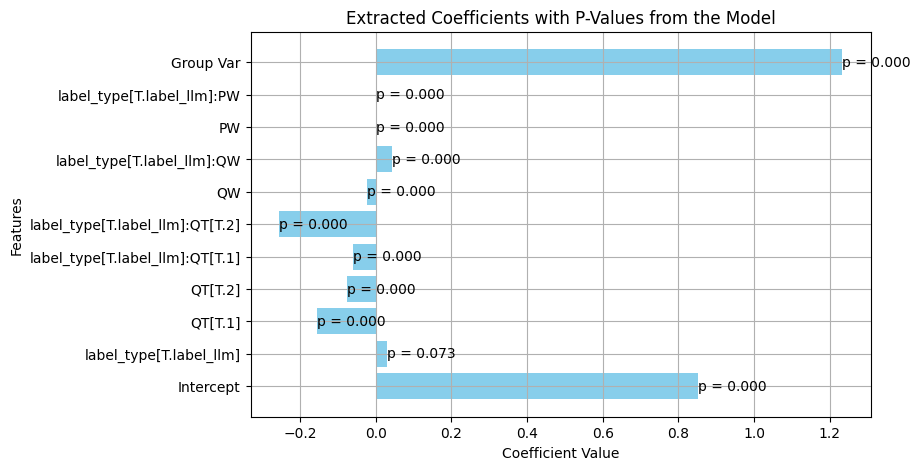

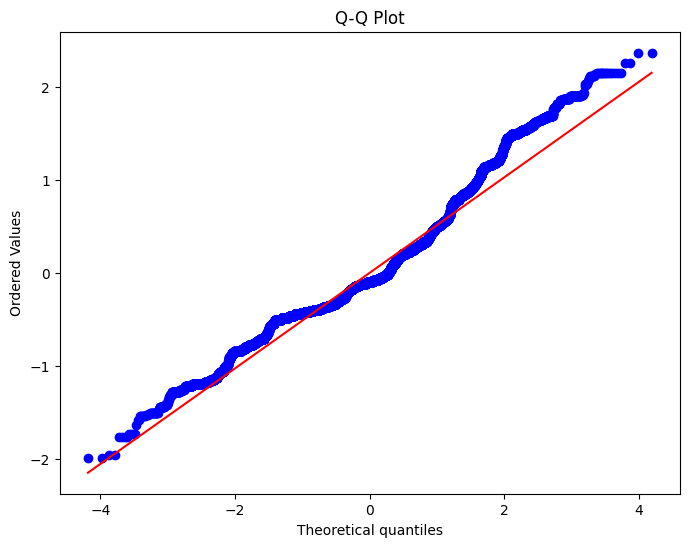

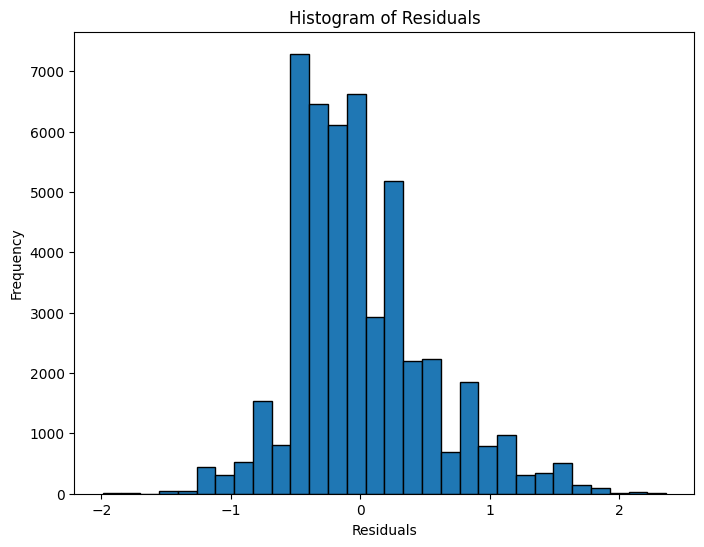

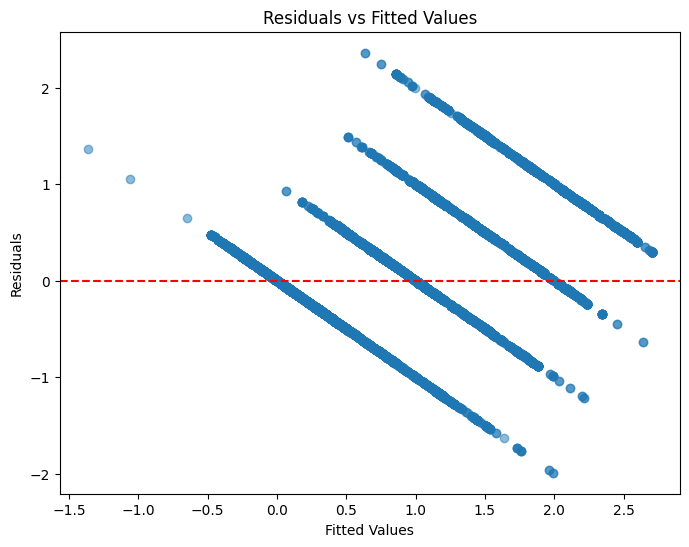

In [61]:
plot_coef(result)
plot_residuals(result)

In [156]:
model = smf.glm(formula=mixed_model, data=data_cat, family=sm.families.Poisson())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  label   No. Observations:                48498
Model:                            GLM   Df Residuals:                    48488
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -56120.
Date:                Mon, 07 Oct 2024   Deviance:                       60056.
Time:                        17:03:22   Pearson chi2:                 5.85e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.08299
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.0170      0.024     -0.715      0.475      -0.064       0.030
label_type[T.label_llm]            -0.1230      0.031     -3.964      0.000      -0.184      -0.062
QT[T.1]                            -0.3442      0.024    -14.131      0.000      -0.392      -0.296
QT[T.2]                            -0.0801      0.028     -2.892      0.004      -0.134      -0.026
label_type[T.label_llm]:QT[T.1]     0.0433      0.032      1.370      0.171      -0.019       0.105
label_type[T.label_llm]:QT[T.2]    -0.2598      0.036     -7.235      0.000      -0.330      -0.189
QW                                 -0.0383      0.004    -10.093      0.000      -0.046      -0.031
label_type[T.label_llm]:QW          0.0594      0.005     12.278      0.000       0.050       0.069
PW                                 -0.0016   1.34e-06  -1206.845      0.000      -0.002      -0.002
label_type[T.label_llm]:PW          0.0016   3.41e-06    464.127      0.000       0.002       0.002
===================================================================================================
"""

In [157]:
model = smf.glm(formula=mixed_model, data=data_cat, family=sm.families.NegativeBinomial())
result = model.fit()
result.summary()

/Users/varsha/opt/anaconda3/envs/biassynthdata_saeed/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  label   No. Observations:                48498
Model:                            GLM   Df Residuals:                    48488
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -56305.
Date:                Mon, 07 Oct 2024   Deviance:                       37715.
Time:                        17:12:48   Pearson chi2:                 4.07e+05
No. Iterations:                    14   Pseudo R-squ. (CS):            0.06232
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.3507      0.040      8.788      0.000       0.272       0.429
label_type[T.label_llm]            -0.4699      0.048     -9.690      0.000      -0.565      -0.375
QT[T.1]                            -0.3468      0.030    -11.378      0.000      -0.407      -0.287
QT[T.2]                            -0.0913      0.035     -2.589      0.010      -0.160      -0.022
label_type[T.label_llm]:QT[T.1]     0.0459      0.041      1.133      0.257      -0.034       0.125
label_type[T.label_llm]:QT[T.2]    -0.2259      0.047     -4.799      0.000      -0.318      -0.134
QW                                 -0.0361      0.005     -7.422      0.000      -0.046      -0.027
label_type[T.label_llm]:QW          0.0531      0.006      8.268      0.000       0.041       0.066
PW                                 -0.0087      0.000    -17.709      0.000      -0.010      -0.008
label_type[T.label_llm]:PW          0.0086      0.000     17.654      0.000       0.008       0.010
===================================================================================================
"""

Coefficients from the model:
P-values from the model:


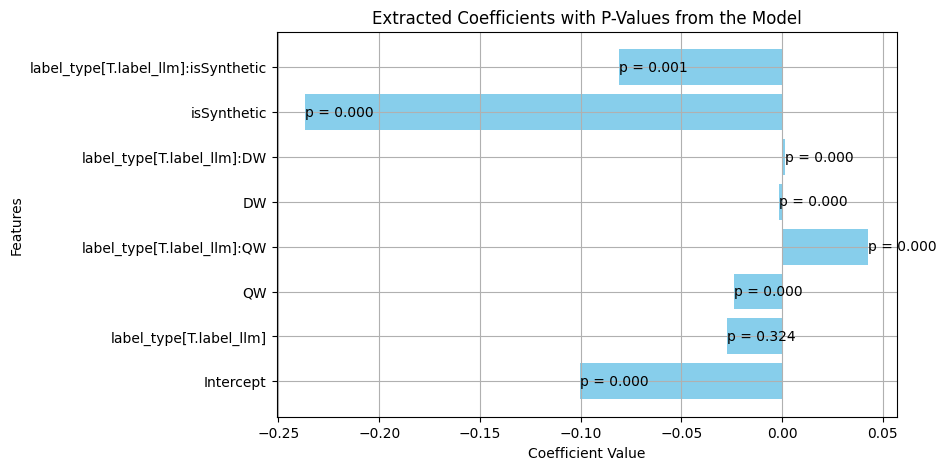

In [35]:
plot_coef(result)

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel



# Fit ordinal logistic regression model
model = OrderedModel(data_cat['label'], exog, distr='logit')
result = model.fit(method='bfgs')

# Print the summary
print(result.summary())

In [ ]:
mixed_model_int = "score ~ isGPT4 + Judge + QL + QDR + QW + C(LLM, Treatment(reference='Other')) + C(Judge, Treatment(reference='nist')) * C(LLM, Treatment(reference='Other')) + isGPT4 * C(LLM, Treatment(reference='Other')) + pipeline"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_int, data, groups=data["run_id"])
result = model.fit()
result.summary()

In [ ]:
real_queries_real_judgments = data[((data['Judge'] == 'nist') & (data['qid'].isin(real_queries_judged)))]
synthetic_queries_real_judgments = data[((data['Judge'] == 'nist') & (data['qid'].isin(t5_queries_judged) | data['qid'].isin(gpt4_queries_judged)))]

In [ ]:
real_queries_synthetic_judgments = data[((data['Judge'] == 'gpt4') & (data['qid'].isin(real_queries_judged)))]
synthetic_queries_synthetic_judgments = data[((data['Judge'] == 'gpt4') & (data['qid'].isin(t5_queries_judged) | data['qid'].isin(gpt4_queries_judged)))]

In [ ]:
mixed_model_condition_Qreal = "score ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline"
mixed_model_condition_Qsynthetic = "score ~ QL + QDS + QW + C(LLM, Treatment(reference='Other')) + pipeline"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qreal, real_queries_real_judgments, groups=real_queries_real_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qsynthetic, synthetic_queries_real_judgments, groups=synthetic_queries_real_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qreal, real_queries_synthetic_judgments, groups=real_queries_synthetic_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qsynthetic, synthetic_queries_synthetic_judgments, groups=synthetic_queries_synthetic_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
real_queries_diff = pd.merge(real_queries_real_judgments, real_queries_synthetic_judgments[['run_id', 'qid', 'score']], on=['run_id', 'qid'], suffixes=('_a', '_b'))
# Subtracting the 'Score' values
real_queries_diff['score_ab'] = real_queries_diff['score_a'] - real_queries_diff['score_b']
real_queries_diff['score_ba'] = real_queries_diff['score_b'] - real_queries_diff['score_a']

In [ ]:
real_queries_diff

In [ ]:
model = sm.MixedLM.from_formula("score_ab ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", real_queries_diff, groups=real_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula("score_ba ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", real_queries_diff, groups=real_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
synthetic_queries_diff = pd.merge(synthetic_queries_real_judgments, synthetic_queries_synthetic_judgments[['run_id', 'qid', 'score']], on=['run_id', 'qid'], suffixes=('_a', '_b'))
# Subtracting the 'Score' values
synthetic_queries_diff['score_ab'] = synthetic_queries_diff['score_a'] - synthetic_queries_diff['score_b']
synthetic_queries_diff['score_ba'] = synthetic_queries_diff['score_b'] - synthetic_queries_diff['score_a']

In [ ]:
synthetic_queries_diff

In [ ]:
model = sm.MixedLM.from_formula("score_ab ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", synthetic_queries_diff, groups=synthetic_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula("score_ba ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", synthetic_queries_diff, groups=synthetic_queries_diff["run_id"])
result = model.fit()
result.summary()

## Extra Experiments (refer to: "Extra Exp. 1")

In [ ]:
def get_result(result_file):
    result_df = pd.read_csv(result_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
    result_df = result_df[result_df['qid'] != 'all']
    result_df['score'] = result_df['score'].astype(float)
    result_df['qid'] = result_df['qid'].astype(int)
    result_df['metric'] = result_df['metric'].apply(lambda x: x.rstrip())
    result_df = result_df[(result_df['metric'] == metric)]
    result_df.drop(['metric'], axis=1, inplace=True)
    return result_df

In [ ]:
real_judge_results = get_result(result_file="results/all.pass.nist.ndcgeval")
synthetic_judge_results = get_result(result_file="results/all.pass.gpt4.ndcgeval")

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
results_diff = pd.merge(real_judge_results, synthetic_judge_results, on=['run_id', 'qid'], suffixes=('_real', '_synthetic'))
# Subtracting the 'Score' values
results_diff['score_RS'] = results_diff['score_real'] - results_diff['score_synthetic']
results_diff['score_SR'] = results_diff['score_synthetic'] - results_diff['score_real']

In [ ]:
results_diff = pd.merge(results_diff, qid_to_info, on='qid')
results_diff = pd.merge(results_diff, model_to_info, on='run_id')

In [ ]:
results_diff

Selected: score_SR

In [ ]:
results_diff['qd_RS'] = results_diff['QDR'] - results_diff['QDS']
results_diff['qd_SR'] = results_diff['QDS'] - results_diff['QDR']

In [ ]:
mixed_model_1 = "score_SR ~ Synthetic + QL + qd_SR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')) + Synthetic * C(LLM, Treatment(reference='Other'))"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_1, results_diff, groups=results_diff["run_id"])
result = model.fit()
result.summary()